In [ ]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import layers as layers
import model as mdl

import warnings
warnings.filterwarnings('ignore')

from costfunctions import mse
import minimizer

In [ ]:
M = mdl.Model()
M.add(layers.ThetaUnitLayer(1,3))
M.add(layers.ThetaUnitLayer(3,1))

In [3]:
def func(x):
    return np.sin(x)

X = np.linspace(0, 10, 5)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None]).reshape((1,X.shape[1]))

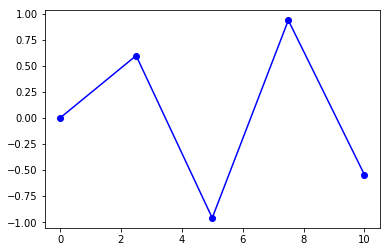

In [4]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [ ]:
minim = minimizer.CMA(True)
minim.train(mse, M, X, Y, tolfun=1e-3)

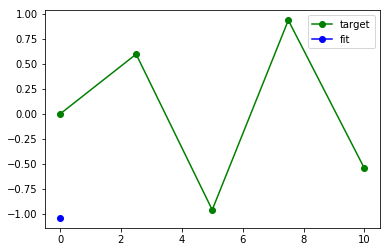

In [5]:
npoints = 5
test_X = (np.linspace(0, 10, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.legend()

# Misc tests

In [6]:
L = layers.MaxPosLayer(3,1)

In [7]:
L.feedin(np.array([Y,2*Y,1*Y]).reshape(3,5))

array([1, 2, 1, 2, 1])

In [8]:
np.array([Y,2*Y,Y]).reshape(3,5)

array([[ 0.        ,  0.59847214, -0.95892427,  0.93799998, -0.54402111],
       [ 0.        ,  1.19694429, -1.91784855,  1.87599995, -1.08804222],
       [ 0.        ,  0.59847214, -0.95892427,  0.93799998, -0.54402111]])

In [9]:
np.empty(0)

array([], dtype=float64)